In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# データフォルダのパス
data_folder = 'edit_data'

# データフォルダ内のすべてのCSVファイルを取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# 各CSVファイルを処理
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    temp_df = pd.read_csv(file_path)
    df = pd.concat([df, temp_df], ignore_index=True)
    
display(df)

,participant_id,time,scale,period,line_width,angle,font_size,stripe_color,text,input_text,accuracy,TorF
0,404,4161.0,50cm,4.0,2.0,135.0,16.0,128.0,8105,8105.0,1.00,T
1,404,4257.0,50cm,8.0,3.0,45.0,16.0,128.0,9106,9106.0,1.00,T
2,404,3598.0,50cm,8.0,2.0,90.0,16.0,128.0,4772,4772.0,1.00,T
3,404,5088.0,50cm,6.0,3.0,135.0,16.0,128.0,9604,8604.0,0.75,F
4,404,5039.0,50cm,0.0,0.0,0.0,16.0,128.0,8736,8736.0,1.00,T
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,417,2249.0,50cm,7.0,2.0,45.0,16.0,128.0,3072,3072.0,1.00,T
1436,417,2207.0,50cm,6.0,1.0,90.0,16.0,128.0,7294,7294.0,1.00,T
1437,417,2814.0,50cm,4.0,1.0,90.0,16.0,128.0,3979,3979.0,1.00,T
1438,417,2386.0,50cm,5.0,2.0,135.0,16.0,128.0,7845,7845.0,1.00,T


scale=intended -> no_stripe_accuracy: 1.00
scale=50cm -> no_stripe_accuracy: 1.00
scale=75cm -> no_stripe_accuracy: 0.98
scale=100cm -> no_stripe_accuracy: 1.00


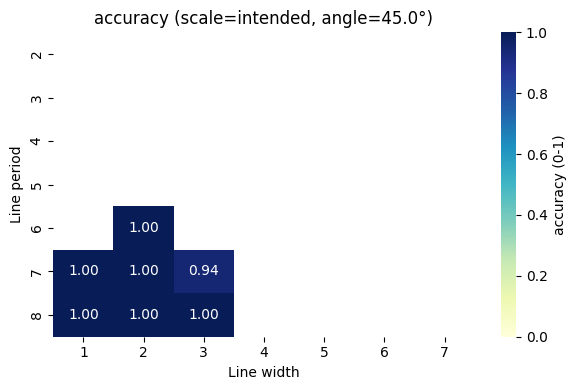

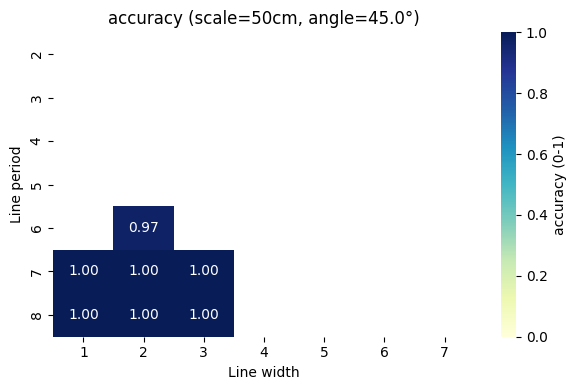

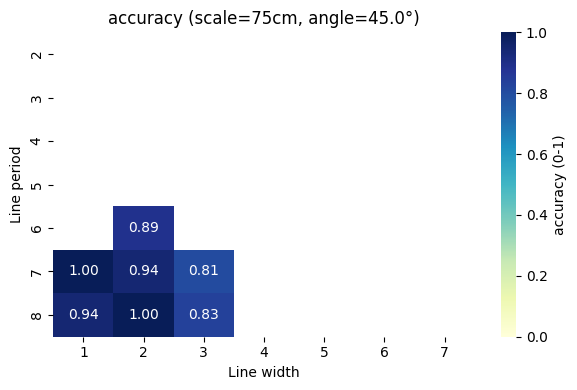

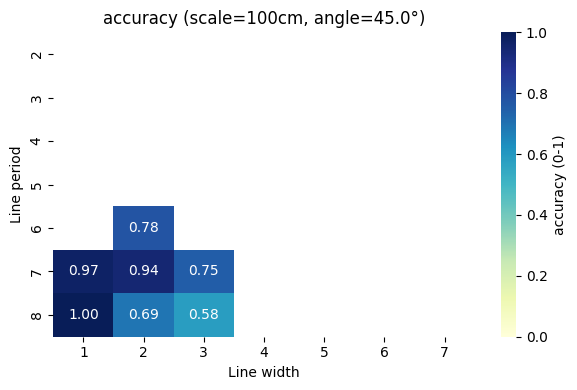

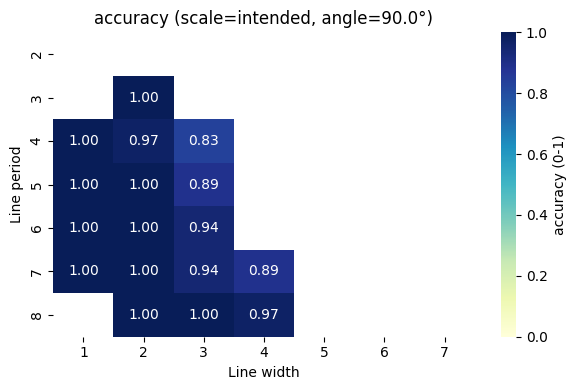

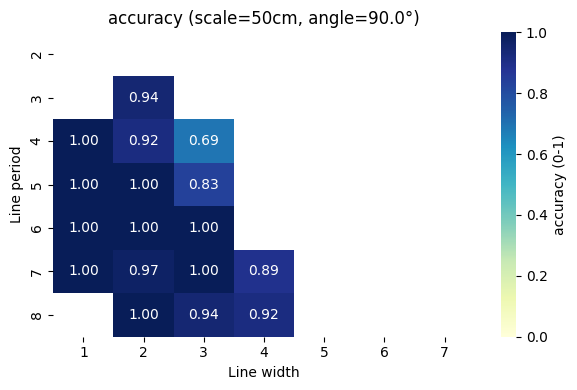

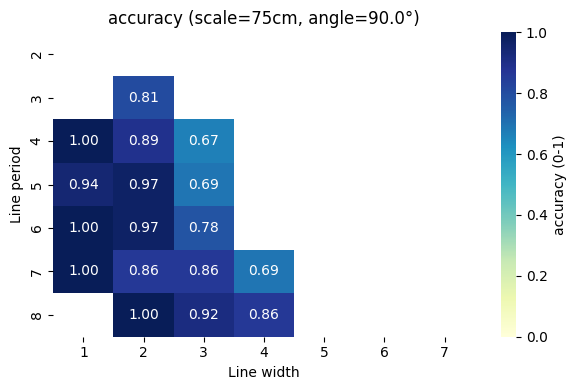

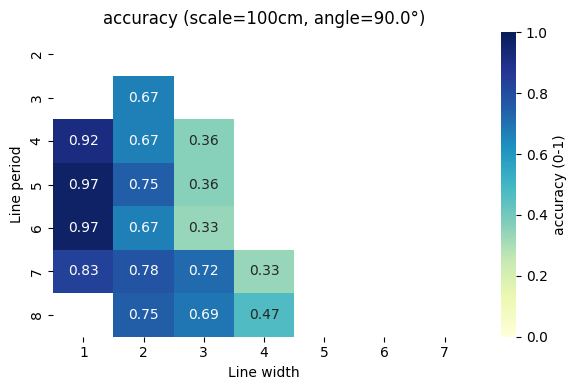

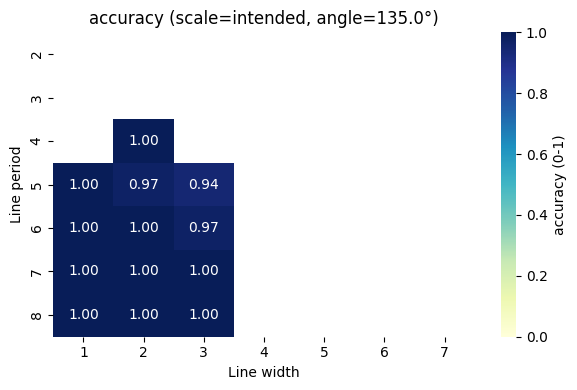

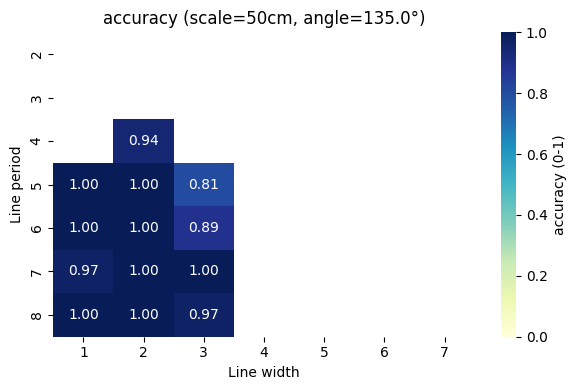

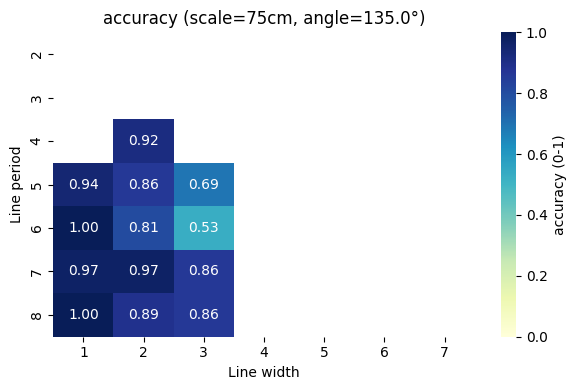

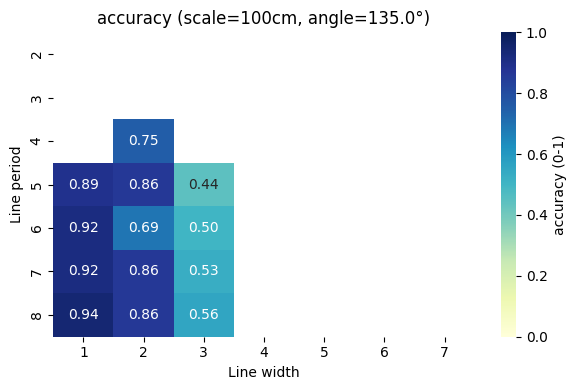

In [3]:
sf_values = sorted(df['scale'].unique())
angle_values = sorted(df['angle'].unique())

# 集計: type, scale_factor, duty_cycle, line_period, line_angle ごとのサマリ
summary = df.groupby(['scale','line_width','period','angle']).agg(
    n=('accuracy','size'),
    mean_acc=('accuracy','mean'),
).reset_index()

# 角度ごとに line_period × line_width の平均精度を計算してヒートマップを描画
for angle in sorted(df['angle'].unique()):
    sub = df[df['angle'] == angle]
    scale_order = ["intended", "50cm", "75cm", "100cm"]
    for scale in scale_order:
        sub_scale = sub[sub['scale'] == scale]

        # グルーピングして平均
        pivot = sub_scale.groupby(['period', 'line_width'])['accuracy'].mean().unstack()
        
        #line_width == 0 のときは精度だけ出力して終了
        if 0 in pivot.columns:
            # 最も小さい period 行から取る（0行が無い可能性を考慮）
            base_period = pivot.index.min()
            no_stripe_acc = pivot.loc[base_period, 0]
            print(f'scale={scale} -> no_stripe_accuracy: {no_stripe_acc:.2f}')
            continue

        #軸を固定
        x_index = list(range(1, 8))
        y_index = list(range(2, 9))
        pivot = pivot.reindex(index=y_index, columns=x_index)

        plt.figure(figsize=(6, 4))
        sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1,
                    cbar_kws={'label': 'accuracy (0-1)'})
        plt.title(f'accuracy (scale={scale}, angle={angle}°)')
        plt.xlabel('Line width')
        plt.ylabel('Line period')
        plt.tight_layout()
        plt.show()


baseline_time = 3263.44 ms

=== angle=0.0° ===
  - scale=intended


C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


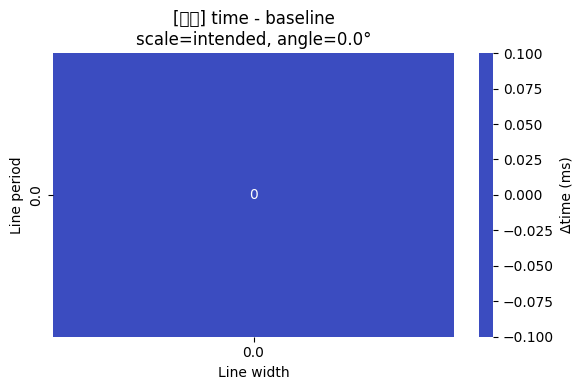

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


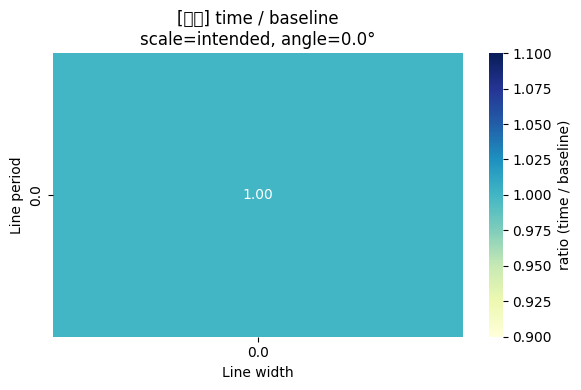

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

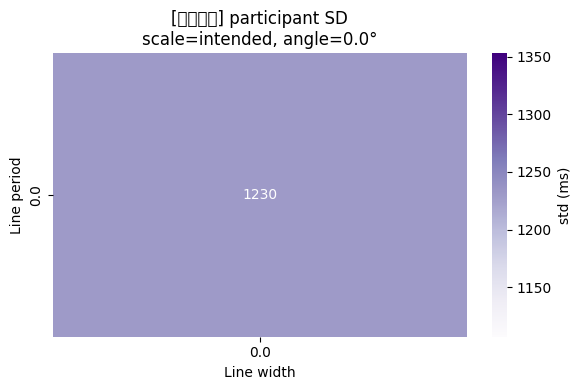

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


  - scale=50cm


c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


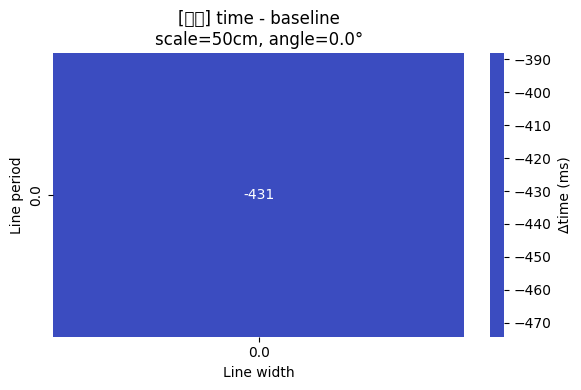

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


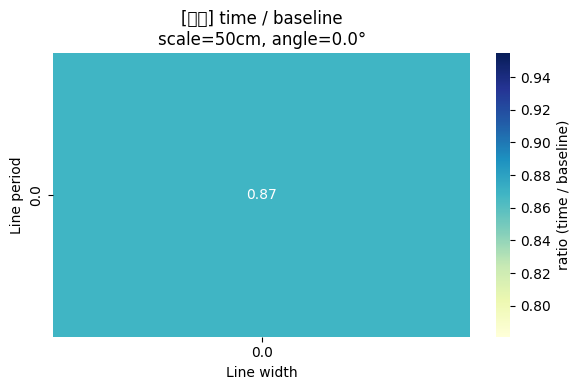

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

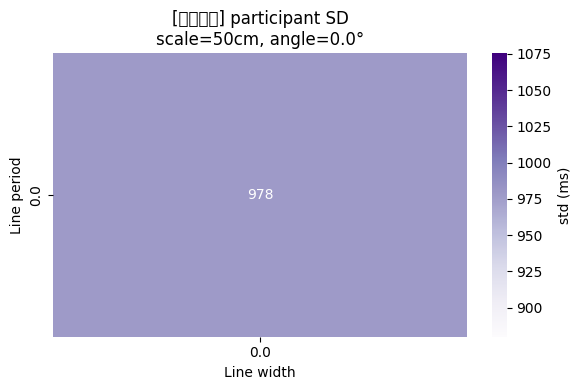

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


  - scale=75cm


c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


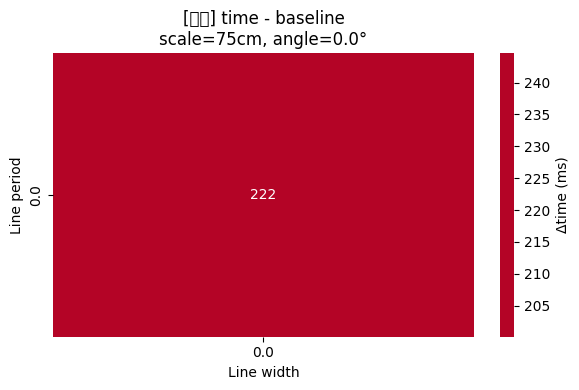

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


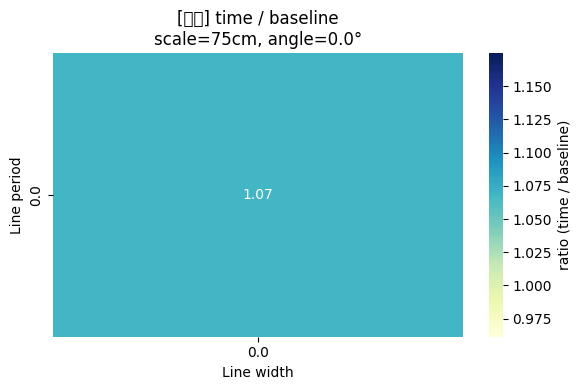

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

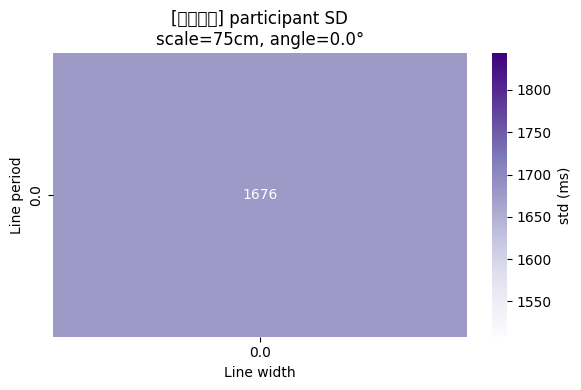

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


  - scale=100cm


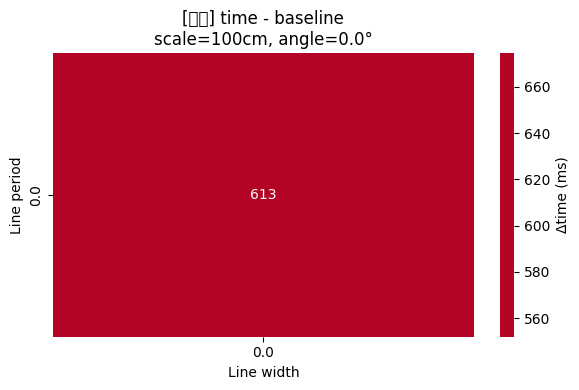

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


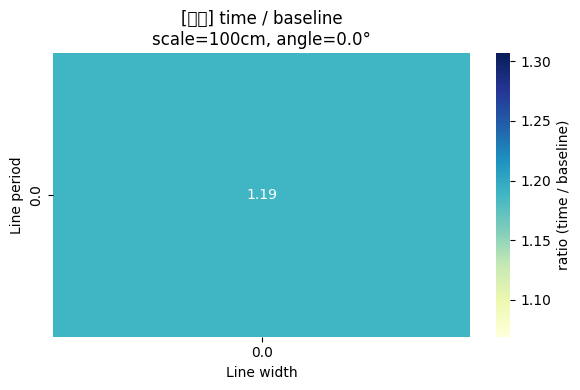

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

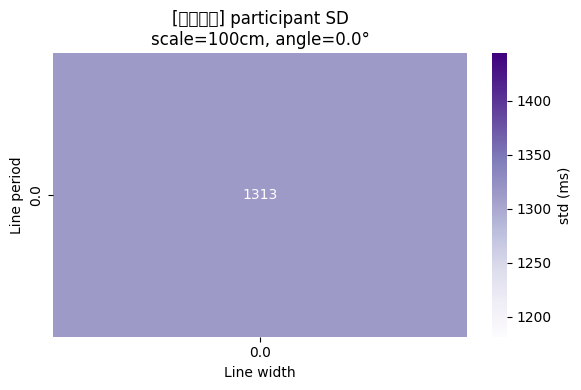

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


=== angle=45.0° ===
  - scale=intended


c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


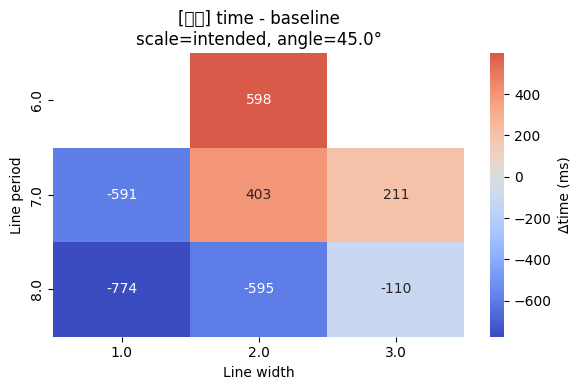

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


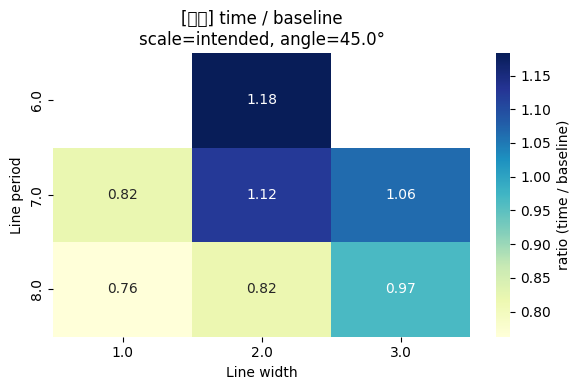

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

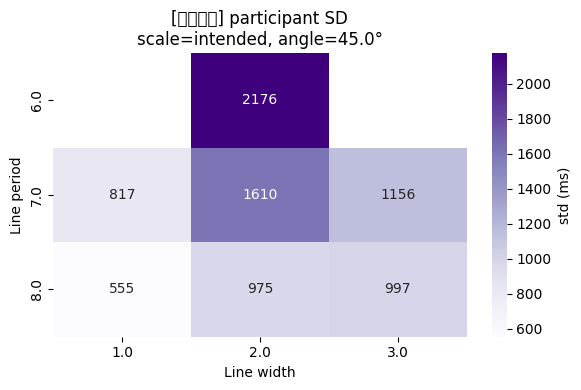

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


  - scale=50cm


C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


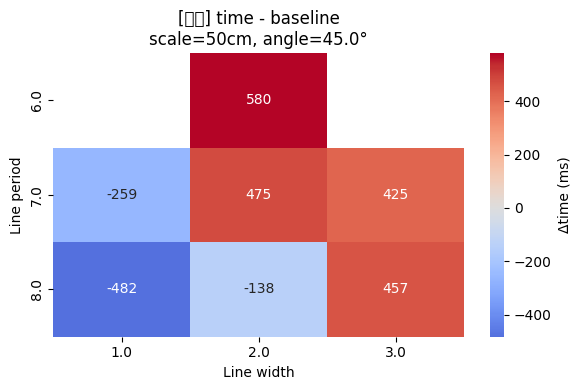

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


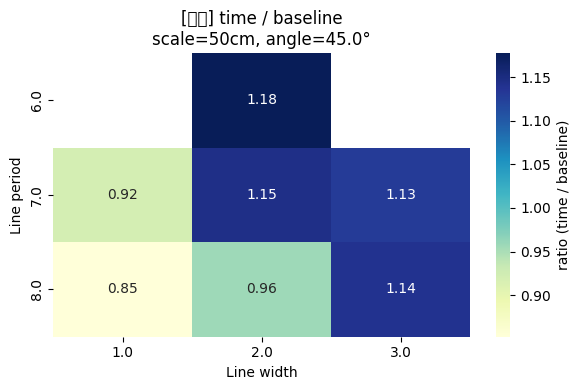

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

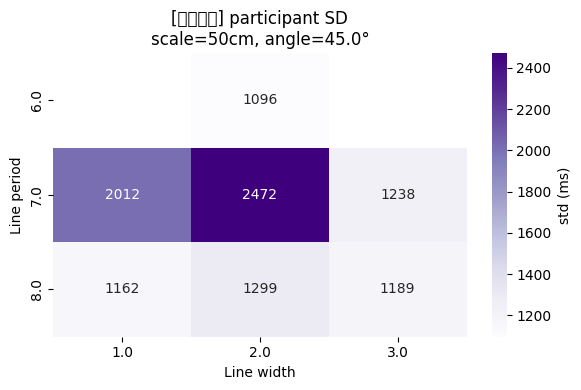

  - scale=75cm


C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


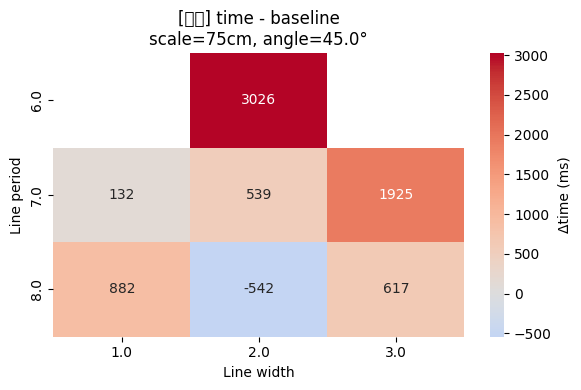

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


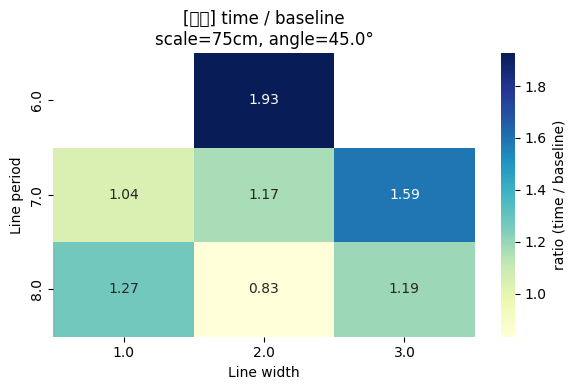

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

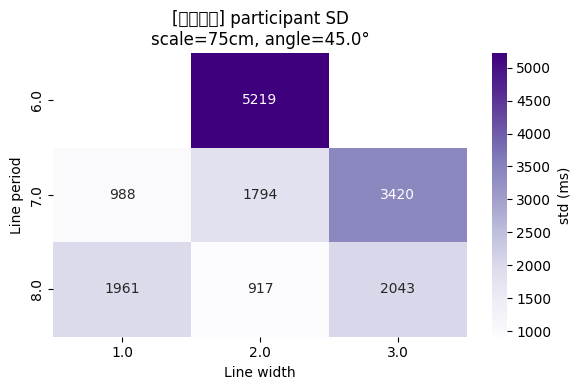

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


  - scale=100cm


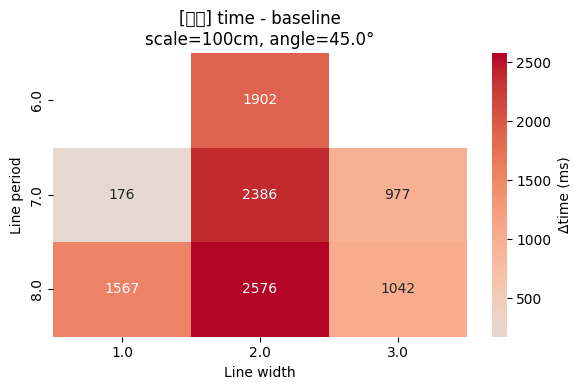

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


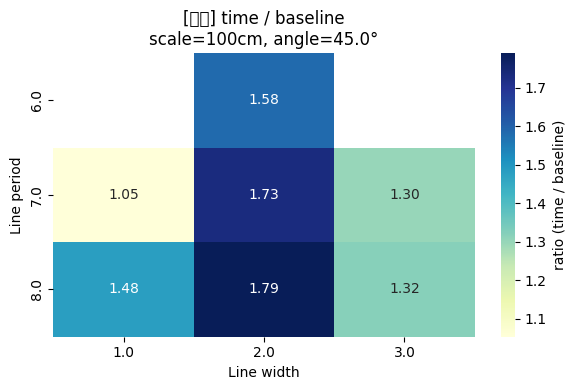

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

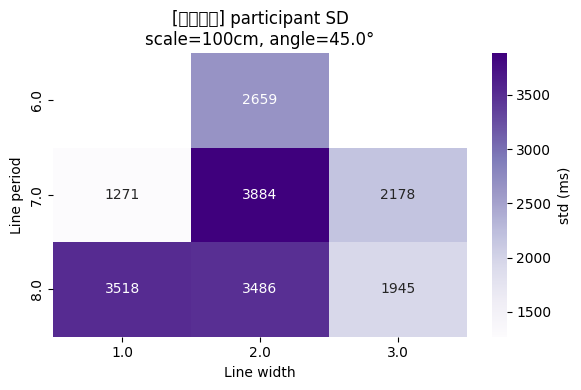

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


=== angle=90.0° ===
  - scale=intended


c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


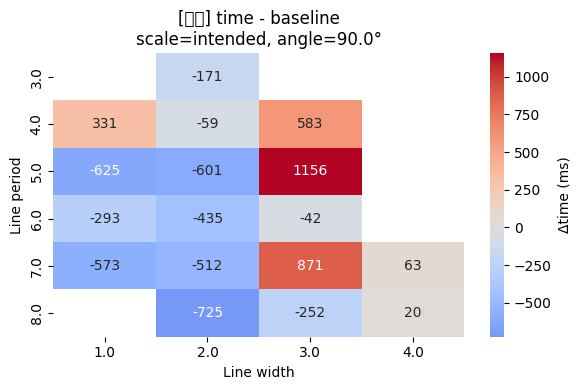

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


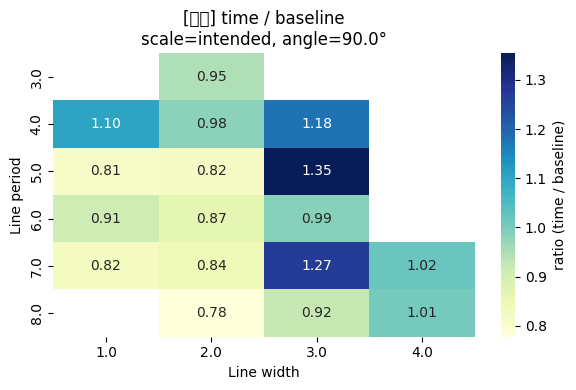

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

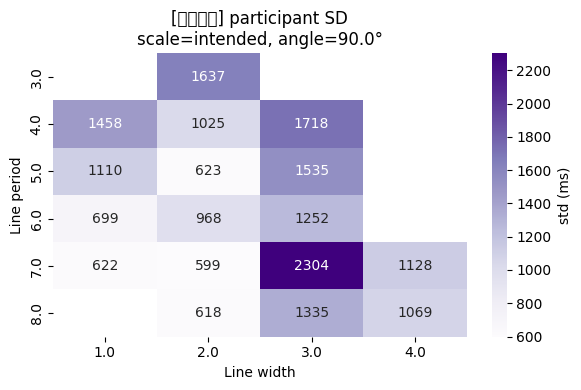

  - scale=50cm


C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


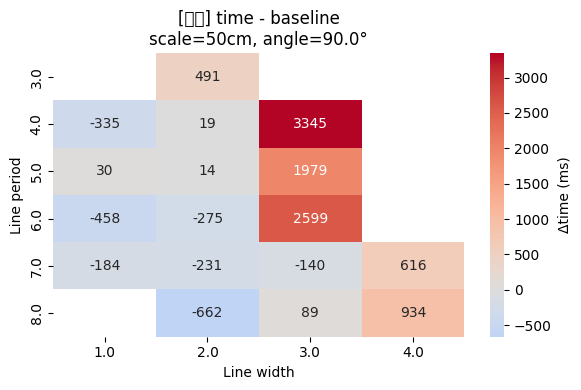

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


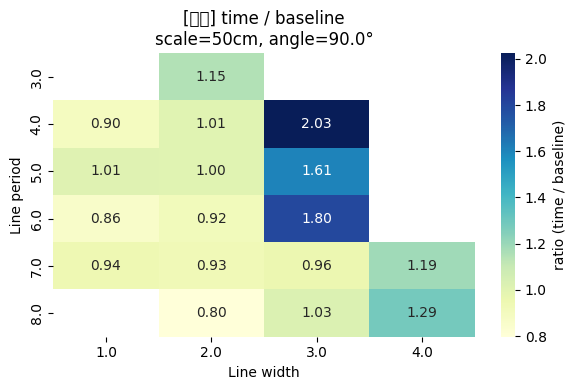

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

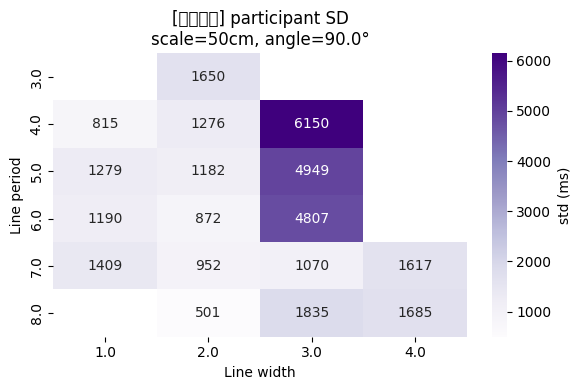

  - scale=75cm


C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


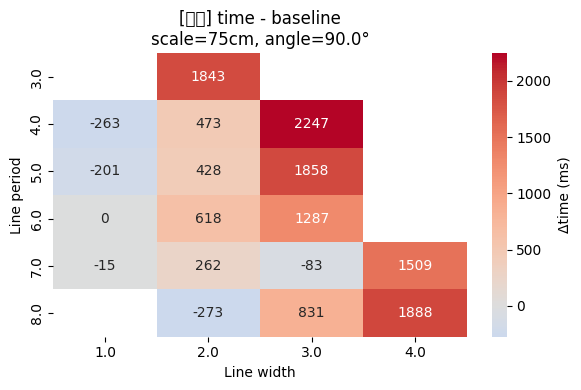

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


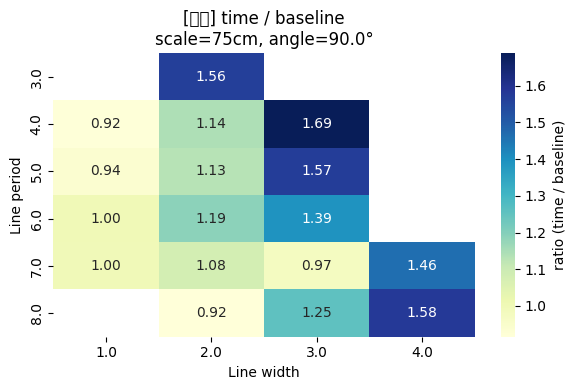

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

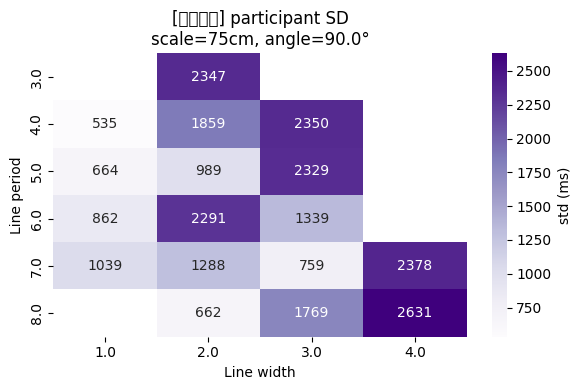

  - scale=100cm


C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


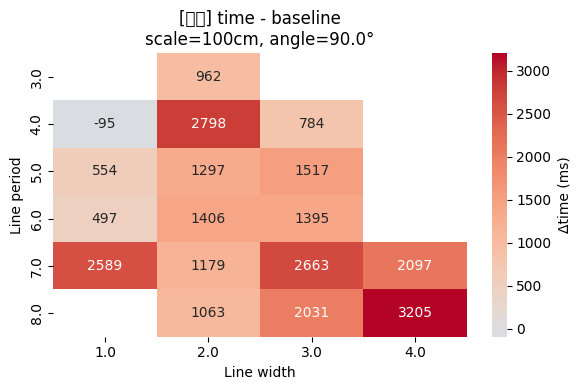

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


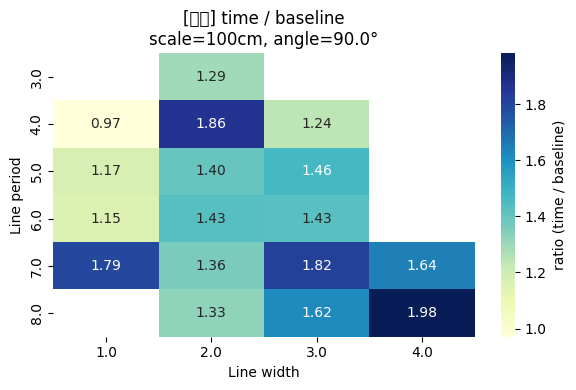

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

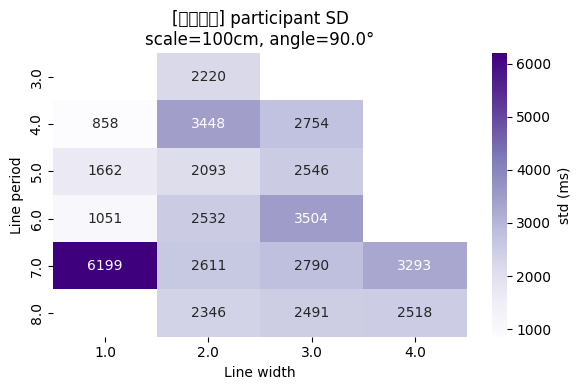

=== angle=135.0° ===
  - scale=intended


C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


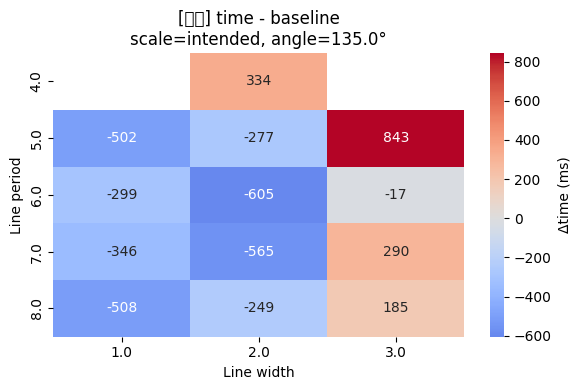

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


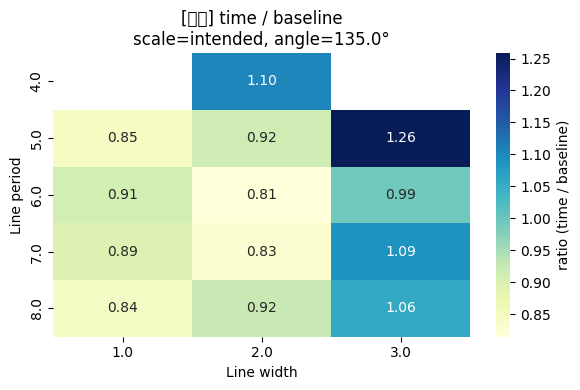

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

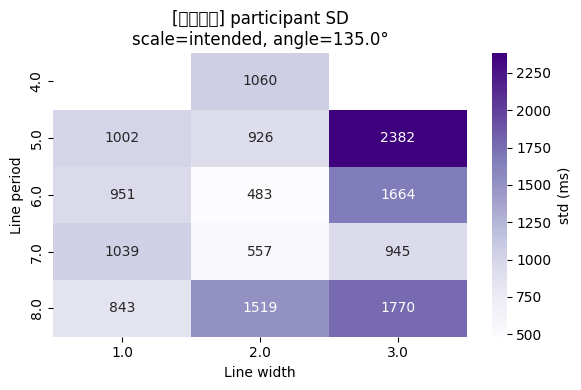

  - scale=50cm


C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


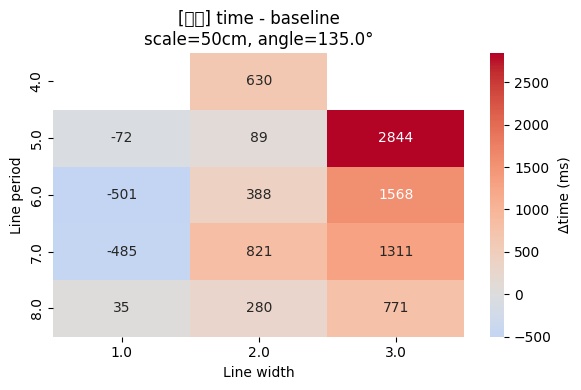

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


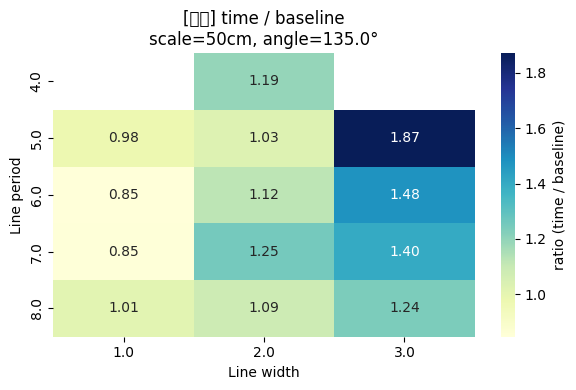

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

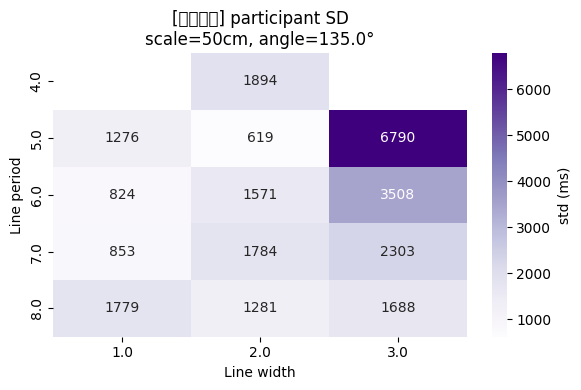

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


  - scale=75cm


c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


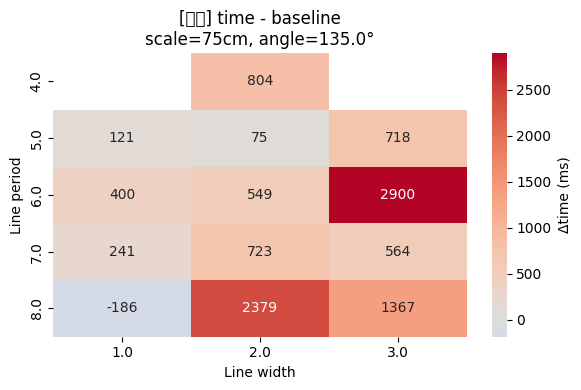

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


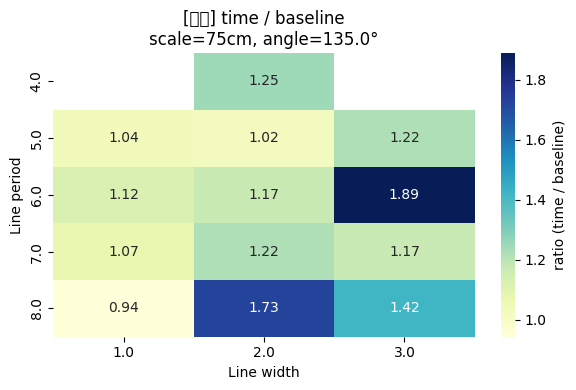

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

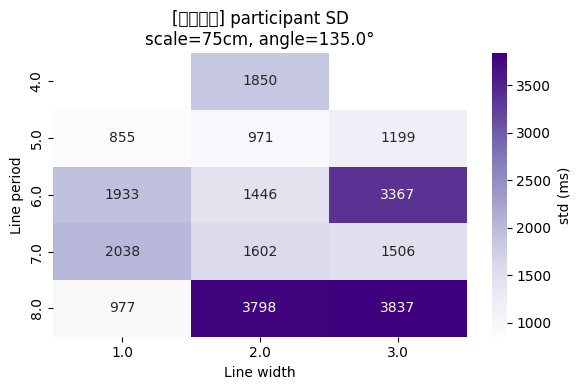

  - scale=100cm


C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:66: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


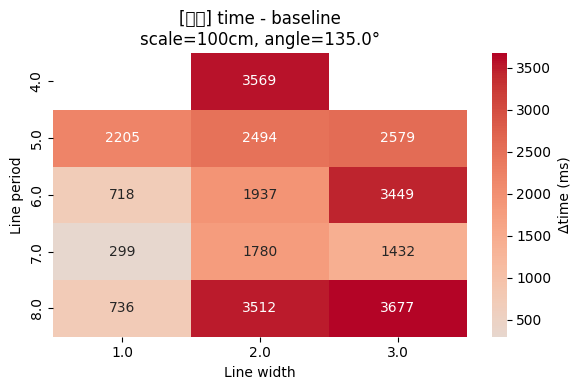

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


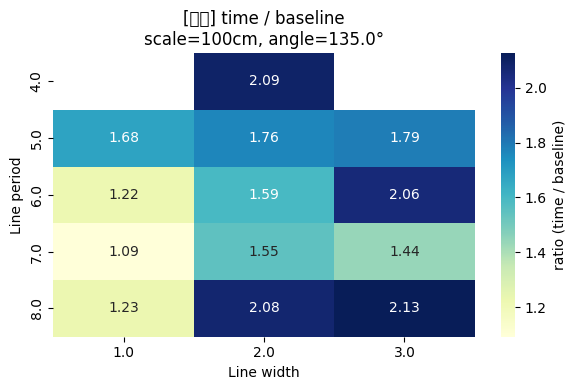

C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryoya\AppData\Local\Temp\ipykernel_6364\3065584158.py:104: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ryoya\_大学\研究室\stripe_experiment\human_ex\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ryoya\_大学\研究室\stripe_experi

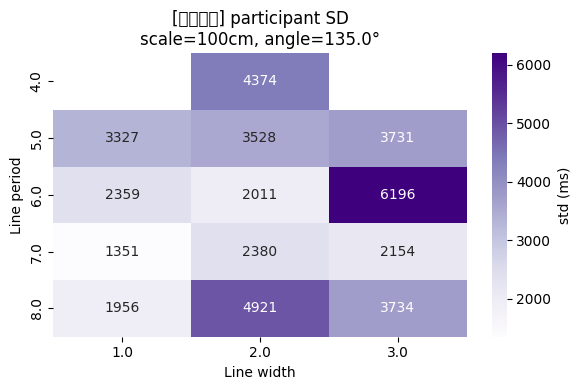

In [ ]:
# ---------------------
# baseline（固定）
# ---------------------
baseline_df = df[(df["scale"] == "intended") & (df["line_width"] == 0.0)]
if len(baseline_df) == 0:
    raise ValueError("baseline(scale='intended', line_width=0.0) が存在しません。")

baseline_time = baseline_df["time"].mean()
print(f"baseline_time = {baseline_time:.2f} ms\n")

scale_order = ["intended", "50cm", "75cm", "100cm"]

# ---------------------
# 角度 × スケールごと分析
# ---------------------
for angle in sorted(df["angle"].unique()):
    print(f"=== angle={angle}° ===")

    angle_df = df[df["angle"] == angle]

    for scale in scale_order:
        print(f"  - scale={scale}")

        sub = angle_df[angle_df["scale"] == scale]
        if len(sub) == 0:
            print("    データなし → skip")
            continue

        # --- 平均値 pivot ---
        pivot_mean = sub.pivot_table(
            index="period",
            columns="line_width",
            values="time",
            aggfunc="mean"
        )

        if pivot_mean.isna().all().all():
            print("    pivot が NaN → skip")
            continue

        # --- 標準偏差 pivot（STEP 3） ---
        pivot_std = sub.pivot_table(
            index="period",
            columns="line_width",
            values="time",
            aggfunc="std"
        )

        # -----------------------------
        # ① baseline との差分
        # -----------------------------
        diff = pivot_mean - baseline_time

        plt.figure(figsize=(6, 4))
        sns.heatmap(
            diff,
            annot=True,
            fmt=".0f",
            cmap="coolwarm",
            center=0,
            cbar_kws={'label': 'Δtime (ms)'}
        )
        plt.title(f"[diff] time - baseline\nscale={scale}, angle={angle}°")
        plt.xlabel("Line width")
        plt.ylabel("Line period")
        plt.tight_layout()
        plt.show()

        # -----------------------------
        # ② baseline 比 (time / baseline)
        # -----------------------------
        ratio = pivot_mean / baseline_time

        plt.figure(figsize=(6, 4))
        sns.heatmap(
            ratio,
            annot=True,
            fmt=".2f",
            cmap="YlGnBu",
            vmin=np.nanmin(ratio.values),
            vmax=np.nanmax(ratio.values),
            cbar_kws={'label': 'ratio (time / baseline)'}
        )
        plt.title(f"[ratio] time / baseline\nscale={scale}, angle={angle}°")
        plt.xlabel("Line width")
        plt.ylabel("Line period")
        plt.tight_layout()
        plt.show()

        # -----------------------------
        # ③ 被験者間の標準偏差
        # -----------------------------
        plt.figure(figsize=(6, 4))
        sns.heatmap(
            pivot_std,
            annot=True,
            fmt=".0f",
            cmap="Purples",
            cbar_kws={'label': 'std (ms)'}
        )
        plt.title(f"[std] participant SD\nscale={scale}, angle={angle}°")
        plt.xlabel("Line width")
        plt.ylabel("Line period")
        plt.tight_layout()
        plt.show()